In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


In [2]:
## Presto stats for reference
effects_ref_marginal <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_marginal.rds')
effects_ref_nested <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds')


In [3]:
## all cells
obj <- readRDS('/data/srlab2/ik936/Roche/data/eczema/obj_all.rds')


In [4]:
## fibroblasts, mapped
fib <- readRDS('/data/srlab2/ik936/Roche/data/eczema/obj_fib.rds')


In [5]:
eff <- fib$query$effects

In [6]:
pryr::object_size(obj)
pryr::object_size(fib)


Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp



1.12 GB

509 MB

Nice cluster names

In [7]:
meta_hs <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/meta_data.rds') %>% 
    dplyr::select(Cluster, Cluster_name) %>% 
    unique() %>% 
    dplyr::mutate(Cluster = paste0('C', Cluster))


In [8]:
fib$query$meta_data <- fib$query$meta_data %>% 
#     dplyr::select(-Cluster_name) %>% 
    left_join(meta_hs)

Joining, by = "Cluster"



# UMAP of types

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Ignoring unknown parameters: width, height”


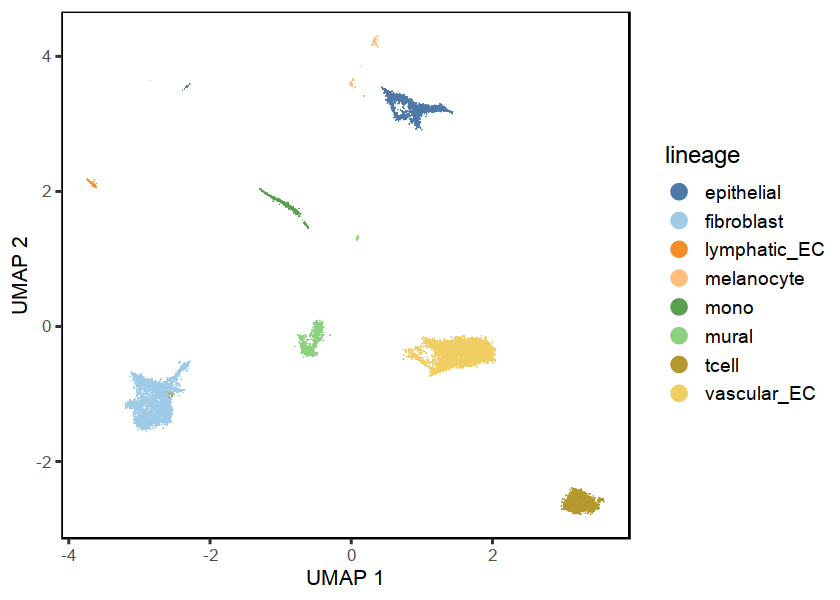

In [9]:
fig.size(5, 7)
p1 <- do_scatter(
    obj$umap_after, obj$meta_data, 'lineage',
    base_size = 14, pt_size = 5,
    do_raster = TRUE, w = 4, h = 3,
    do_labels = FALSE, no_guides = FALSE
)

p1 


# Heatmap of lineage markers

In [10]:
mat <- obj$effects %>% 
    subset(feature %in% c('MLANA', 'KRT15', 'ACKR1', 'COL1A1', 'ACTA2', 'PROX1', 'CD3G', 'FCER1G', 'C1QB')) %>% 
#     dplyr::select(feature, Cluster, zscore) %>% 
#     tidyr::spread(Cluster, zscore) %>% 
    dplyr::select(feature, Cluster, beta) %>% 
    tidyr::spread(Cluster, beta) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() 
    


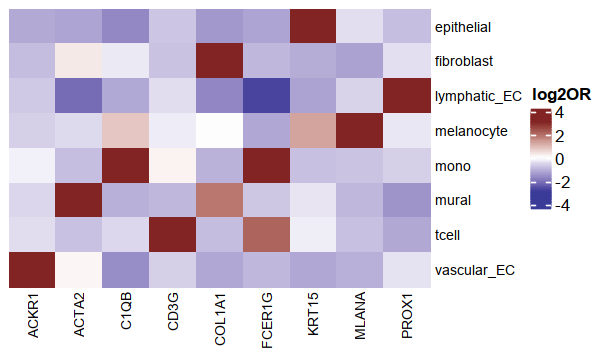

In [11]:
fig.size(3, 5)

ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 8))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 8))

h1 <- Heatmap(
    matrix = t(mat), 
    colorRamp2(c(-3, 0, 3), c(muted('blue'), 'white', muted('red'))),    
    column_names_rot = 90, 
    cluster_columns = FALSE, 
    cluster_rows = FALSE, 
    name = 'log2OR'
)

p2 <- grid.grabExpr(draw(h1))

h1


# marginal conservation heatmap

In [12]:
df_dermal <- fib$query$effects %>% 
    dplyr::select(Cluster, zscore, feature) %>% 
    dplyr::mutate(Cluster = gsub('C', 'dermal_', Cluster)) %>% 
    tidyr::spread(Cluster, zscore) %>% 
    tibble::column_to_rownames('feature')

## Compare to marginal effects
df_ref <- effects_ref_marginal %>% 
    subset(!Cluster %in% c(6, 12, 13)) %>% ## absent in dermal mapping 
    dplyr::select(Cluster, zscore, feature) %>% 
    dplyr::mutate(Cluster = paste0('ref_', Cluster)) %>% 
    tidyr::spread(Cluster, zscore) %>% 
    tibble::column_to_rownames('feature')

genes_use <- intersect(rownames(df_dermal), rownames(df_ref))

cormat <- cor(df_dermal[genes_use, ], df_ref[genes_use, ])
o_row <- order(as.integer(gsub('.*?(\\d+)', '\\1', rownames(cormat))))
o_column <- order(as.integer(gsub('.*?(\\d+)', '\\1', colnames(cormat))))
cormat <- cormat[o_row, o_column]


colnames(cormat) <- gsub('ref_(\\d+)', 'Reference C\\1', colnames(cormat))
rownames(cormat) <- gsub('dermal_(\\d+)', 'Dermal C\\1', rownames(cormat))


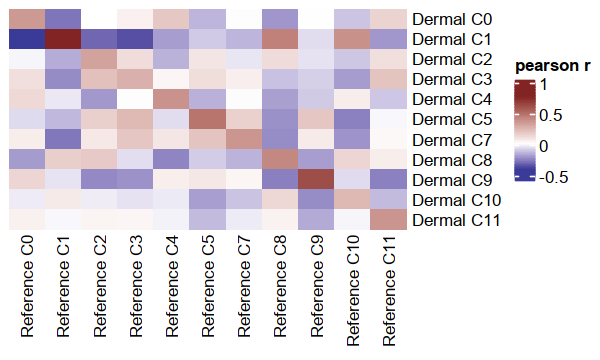

In [13]:
fig.size(3, 5)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 10))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))

h2 <- Heatmap(
    cormat,
    name = 'pearson r',
    cluster_rows = FALSE, 
    cluster_columns = FALSE,
#     colorRamp2(c(min(cormat), 0, max(cormat)), c('white', 'white', muted('red'))),
    colorRamp2(c(min(cormat), 0, max(cormat)), c(muted('blue'), 'white', muted('red'))),
    column_names_rot = 90, 
)
p3 <- grid.grabExpr(draw(h2))
h2


# Inflam forest with histology RE

In [14]:
plt_df <- fib$masc_2 %>% 
# plt_df <- fib$query$masc_inflam2 %>% 
    left_join(meta_hs) %>% 
    dplyr::mutate(Cluster = Cluster_name) %>% 
#     subset(!Cluster %in% paste0('C', c(6, 12, 13))) %>% 
    subset(!grepl('C6$|C12$|C13$', Cluster))

plt_df$fdr <- p.adjust(plt_df$pvalue, 'BH')


Joining, by = "Cluster"



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


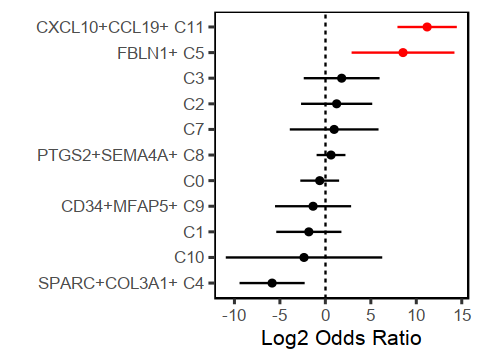

In [15]:
fig.size(3, 4)
# p7 <- fib$query$masc %>% 
p4 <- plt_df %>% 
    forest_uni(sigma_max = Inf, fdr_max = 0.1, beta_min = 0) + 
    labs(y = 'Log2 Odds Ratio') + 
#     scale_x_discrete(position = 'top') + 
    NULL

p4


In [16]:
log(0.5) / log(2)

[1] -1

In [17]:
fib$query$masc_ec %>% subset(Cluster == 'C4')
fib$query$masc_mural %>% subset(Cluster == 'C4')



Cluster,Ncells,beta,sigma,zscore,pvalue
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
C4,283,2.485105,1.427374,1.741033,0.04083887


Cluster,Ncells,beta,sigma,zscore,pvalue
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
C4,283,3.239828,0.7569203,4.280276,9.333101e-06


In [18]:
fib$masc_2

Cluster,Ncells,beta,sigma,zscore,pvalue,Z,pval,fdr
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C11,158,11.1920427,1.666046e+00,6.717725316,1.845832e-11,6.717725316,1.845835e-11,2.584168e-10
C5,1063,8.5402712,2.886058e+00,2.959147552,3.084914e-03,2.959147552,3.084914e-03,1.439626e-02
C3,72,1.7923660,2.127713e+00,0.842390675,3.995693e-01,0.842390675,3.995693e-01,7.541628e-01
C2,78,1.2403287,1.997174e+00,0.621041815,5.345721e-01,0.621041815,5.345721e-01,7.541628e-01
C7,1211,0.9670040,2.489996e+00,0.388355688,6.977528e-01,0.388355688,6.977528e-01,8.140450e-01
C8,166,0.6223865,8.093141e-01,0.769029599,4.418757e-01,0.769029599,4.418757e-01,7.541628e-01
C0,130,-0.6220468,1.088896e+00,-0.571263884,5.678208e-01,-0.571263884,5.678208e-01,7.541628e-01
C9,864,-1.3522255,2.135027e+00,-0.633352754,5.265033e-01,-0.633352754,5.265033e-01,7.541628e-01
C1,3414,-1.8180593,1.828309e+00,-0.994393629,3.200313e-01,-0.994393629,3.200313e-01,7.541628e-01


## COL6A5+ comparison

### Enrichment

In [19]:
gsea_res <- readRDS('/data/srlab2/ik936/Roche/data/eczema/cache_gsea.rds')

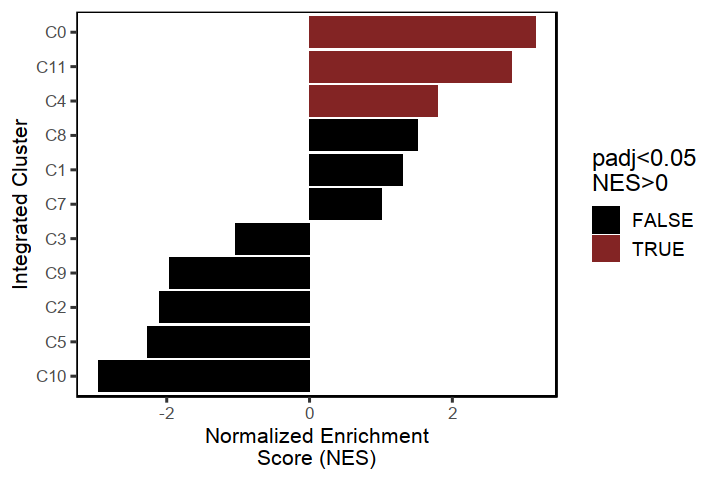

In [20]:
fig.size(4, 6)
p5 <- gsea_res %>% arrange(-NES) %>% 
#     ggplot(aes(reorder(Cluster, NES), sign(ES)*-log10(padj))) + 
    ggplot(aes(reorder(Cluster, NES), NES, fill = padj < .01 & NES > 0)) + 
        geom_bar(stat = 'identity') + 
        coord_flip() + 
        scale_fill_manual(values = c('black', muted('red'))) + 
        labs(
            y = 'Normalized Enrichment\nScore (NES)', x = 'Integrated Cluster',
            fill = 'padj<0.05\nNES>0'
#             , subtitle = 'Enrichment of COL6A5+COL18A1+ signature'
        ) + 
        NULL

#%>% subset(padj < .01 & NES > 0)
p5

### Volcano

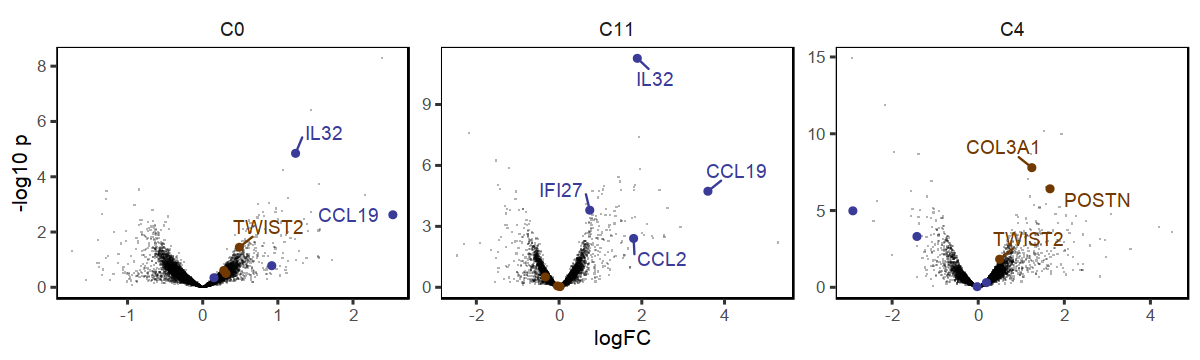

In [21]:
fig.size(3, 10)
set.seed(43)
p6 <- eff %>% 
    subset(Cluster %in% c('C0', 'C4', 'C11')) %>% 
#     ggplot(aes(beta, abs(zscore))) + 
    ggplot(aes(beta, -log10(pvalue))) + 
        geom_point(shape = '.', alpha = .3) + 
        geom_point(data = . %>% subset(feature %in% c('POSTN', 'COL3A1', 'TWIST2')), color = muted('orange')) +
        geom_point(data = . %>% subset(feature %in% c('IFI27', 'IL32', 'CCL19', 'CCL2', 'IL32')), color = muted('blue')) +
        geom_text_repel(
            seed = 50, 
            data = . %>% subset(feature %in% c('POSTN', 'COL3A1', 'TWIST2') & pvalue < .1 & beta > 0),
            color = muted('orange'),
            aes(label = feature),
            box.padding = .5
        ) + 
        geom_text_repel(
            seed = 44, 
            data = . %>% subset(feature %in% c('IFI27', 'IL32', 'CCL19', 'CCL2', 'IL32') & pvalue < .1 & beta > 0),
            color = muted('blue'),
            aes(label = feature),
            box.padding = .5
        ) + 
        facet_wrap(~Cluster, scales = 'free') + 
        labs(x = 'logFC', y = '-log10 p') + 
        NULL
p6

### Scatter

In [22]:
.x <- eff %>% 
    dplyr::select(feature, Cluster, zscore) %>% 
    tidyr::spread(Cluster, zscore, fill = 0) 
genesets_enrichr <- readRDS('/data/srlab2/ik936/Roche/data/pathways/db.rds')
# db_use <- names(genesets_enrichr) %>% setdiff(c('LINCS_L1000_Chem_Pert_down', 'LINCS_L1000_Chem_Pert_up'))
db_use <- grep('^H$|^GO_', names(genesets_enrichr), value = TRUE)
genesets_enrichr <- genesets_enrichr[db_use]

genesets_enrichr <- genesets_enrichr %>% 
    imap(function(.SD, name) {
        names(.SD) <- paste(name, names(.SD), sep = ':')
        return(.SD)
    }) %>% 
    purrr::reduce(c)


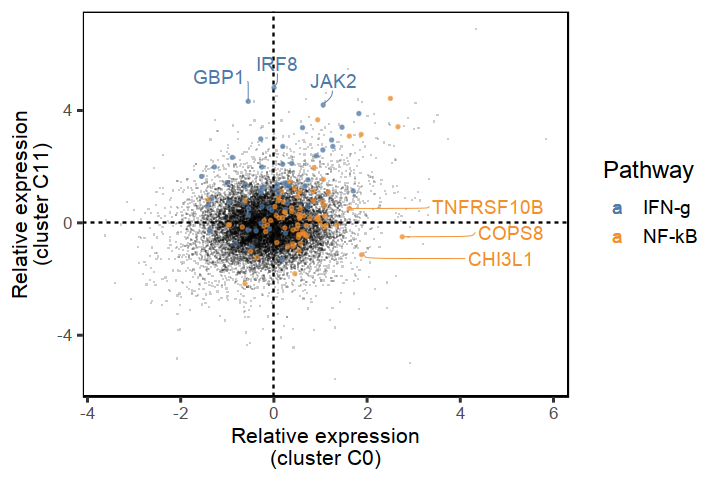

In [23]:
p7 <- .x %>% 
    dplyr::mutate(LABEL = case_when(
        feature %in% genesets_enrichr[['GO_Biological_Process_2018:NIK/NF-kappaB signaling (GO:0038061)']] ~ 'NF-kB',
        feature %in% genesets_enrichr[['GO_Biological_Process_2018:interferon-gamma-mediated signaling pathway (GO:0060333)']] ~ 'IFN-g',
        TRUE ~ ''
    )) %>% 
#     dplyr::arrange() %>% 
    ggplot(aes(C0, C11)) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_point(shape = '.', alpha = .2) + 
        geom_point(
            data = . %>% subset(LABEL != ''),
            aes(color = LABEL),
            size = .5, 
            alpha = .6
        ) + 
        geom_text_repel(
            data = . %>% subset(LABEL == 'IFN-g' & C0 < 2) %>% arrange(-C11) %>% head(3), 
            force             = 0.5,
            nudge_y           = 0.85,
            direction         = "x",
#             vjust             = 0,
            segment.size      = 0.2,
            segment.curvature = -0.1,            
 
            aes(label = feature, color = LABEL),
        ) + 
        geom_text_repel(
            data = . %>% subset(LABEL == 'NF-kB' & C11 < 2) %>% arrange(-C0) %>% head(3), 
            force             = 0.75,
            nudge_x           = 1.25,
            direction         = "y",
            hjust             = -1,
            segment.size      = 0.2,
            segment.curvature = -0.1,            
            aes(label = feature, color = LABEL),
        ) + 
        scale_color_tableau() + 
        labs(
            x = 'Relative expression\n(cluster C0)', y = 'Relative expression\n(cluster C11)', 
#             subtitle = 'Dermal Inflammatory Fibroblasts', 
            color = 'Pathway'
        ) + 
        NULL

fig.size(4, 6)

p7

# Arrange panels

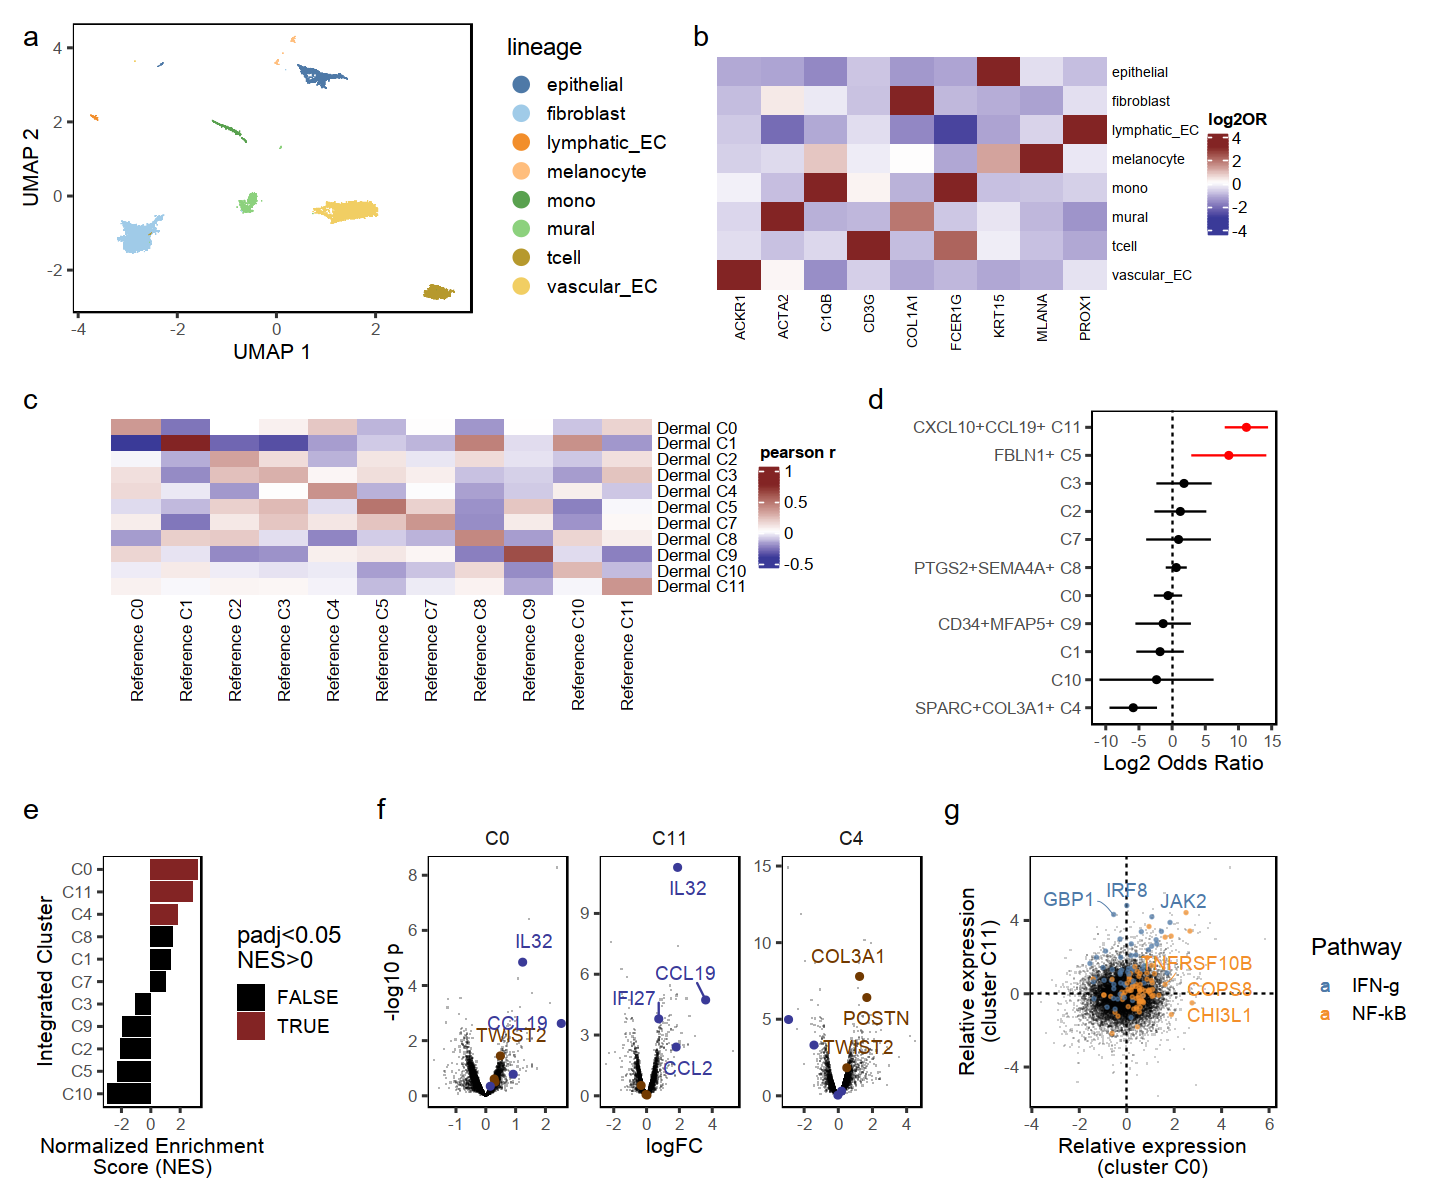

In [24]:
fig.size(10, 12)
(
    (
        (wrap_elements(full = p1) | wrap_elements(panel = p2)) + plot_layout(widths = c(1, 1))
    ) / (
        (wrap_elements(panel = p3) | p4) + plot_layout(widths = c(4, 1))
    ) / (
        (p5 | p6 | p7) + plot_layout(widths = c(.4, 2, 1))
#         (wrap_elements(full = p5) | wrap_elements(full = p6) | wrap_elements(full = p7)) + plot_layout(widths = c(.4, 2, 1))
    )
) + 
    plot_layout(heights = c(1, 1, .8)) + 
    plot_annotation(tag_levels = 'a')


In [26]:
ggsave(
    filename = '/data/srlab2/ik936/Roche/manuscript/figures/SuppFigure9.pdf', 
    units = 'in', device = 'pdf', 
    height = 10, width = 12,
    useDingbats = FALSE
)
